# Load settings

In [1]:
exec(open('/Users/ricard/10x_gastrulation_TetChimera/settings.py').read())

/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [135]:
%%capture
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [2]:
opts.keys()

dict_keys(['celltypes', 'celltype.colors', 'stages_colors', 'batches', 'classes'])

In [3]:
io.keys()

dict_keys(['basedir', 'atlas.basedir', 'gene_metadata', 'metadata', 'atlas.metadata'])

# Create anndata object

In [55]:
opts["batches"]

['E75_TET_TKO_L002']

In [56]:
anndatas = [None for i in range(len(opts["batches"]))]
for i in range(len(opts["batches"])):
    batch = opts["batches"][i]
    anndatas[i] = sc.read_10x_mtx(path=io["basedir"]+"/original/no_tomato/second_batch", prefix=batch+"_")
    anndatas[i].obs["batch"] = batch
    print(batch)
    print(anndatas[i].shape)

/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(6832, 64591)


In [119]:

anndatas[i].shape

(6832, 64591)

Concatenate anndata experiments

In [120]:
adata = anndata.AnnData.concatenate(*anndatas, join='inner', batch_key='batch')
print(adata.shape)

(6832, 64591)


In [121]:
adata.obs["cell"] = adata.obs["batch"] + "_" + adata.obs.index
adata.obs.head()

,batch,cell
AAACCCACACACCTGG-1,E75_TET_TKO_L002,E75_TET_TKO_L002_AAACCCACACACCTGG-1
AAACCCACACTAGAGG-1,E75_TET_TKO_L002,E75_TET_TKO_L002_AAACCCACACTAGAGG-1
AAACCCAGTGACGTCC-1,E75_TET_TKO_L002,E75_TET_TKO_L002_AAACCCAGTGACGTCC-1
AAACCCATCACACCGG-1,E75_TET_TKO_L002,E75_TET_TKO_L002_AAACCCATCACACCGG-1
AAACCCATCTCGCCTA-1,E75_TET_TKO_L002,E75_TET_TKO_L002_AAACCCATCTCGCCTA-1


Sanity checks

In [122]:
adata.obs.index.duplicated().sum()

0

In [123]:
adata.var.index.duplicated().sum()

0

Merge with existing

In [71]:
metadata = pd.read_csv("/Users/ricard/data/10x_gastrulation_TetChimera/sample_metadata.txt.gz", sep="\t")
metadata.set_index("cell", drop=False)
metadata.head()

,cell,barcode,batch,stage,class,target,nCount_RNA,nFeature_RNA,percent.mt,doublet_score,pass_QC,celltype.mapped,stage.mapped,closest.cell,celltype.score,cellstage.score,embryo
0,E75_TET_TKO_L002_AAACCCACACACCTGG-1,AAACCCACACACCTGG-1,E75_TET_TKO_L002,E7.5,E7.5_TET_TKO,TET,31953,5212,3.076393,1267.393422,False,Surface ectoderm,E7.0,cell_108742,0.400000,0.300000,E7.5_embryo1
1,E75_TET_TKO_L002_AAACCCACACTAGAGG-1,AAACCCACACTAGAGG-1,E75_TET_TKO_L002,E7.5,E7.5_TET_TKO,TET,28739,4486,2.654929,13.517984,True,Rostral neurectoderm,E7.5,cell_50749,0.966667,0.400000,E7.5_embryo1
2,E75_TET_TKO_L002_AAACCCAGTGACGTCC-1,AAACCCAGTGACGTCC-1,E75_TET_TKO_L002,E7.5,E7.5_TET_TKO,TET,22042,4115,3.202976,18.639129,True,Mesenchyme,E7.5,cell_82737,0.833333,0.366667,E7.5_embryo1
3,E75_TET_TKO_L002_AAACCCATCACACCGG-1,AAACCCATCACACCGG-1,E75_TET_TKO_L002,E7.5,E7.5_TET_TKO,TET,7442,2525,2.176834,NaN,False,NaN,NaN,NaN,NaN,NaN,E7.5_embryo1
4,E75_TET_TKO_L002_AAACCCATCTCGCCTA-1,AAACCCATCTCGCCTA-1,E75_TET_TKO_L002,E7.5,E7.5_TET_TKO,TET,23174,4565,2.709934,258.699802,True,ExE mesoderm,mixed_gastrulation,cell_56374,0.600000,0.466667,E7.5_embryo1


Add updated metadata to the anndata object

In [124]:
foo = pd.merge(left=adata.obs, right=metadata, left_on=["cell","batch"], right_on=['cell',"batch"]).set_index("cell")

In [125]:
adata.obs = foo
adata.shape

(6832, 64591)

# Save anndata object

In [99]:
adata.write_h5ad("/Users/ricard/data/10x_gastrulation_TetChimera/processed/second_batch/anndata.h5ad")

/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'batch' as categorical
... storing 'stage' as categorical
... storing 'class' as categorical
... storing 'target' as categorical
... storing 'celltype.mapped' as categorical
... storing 'stage.mapped' as categorical
... storing 'closest.cell' as categorical
... storing 'embryo' as categorical
... storing 'feature_types' as categorical


In [134]:
# adata.var_names.str.contains("GRCh38").mean()

0.5192364261274791

In [223]:
adata_qc = adata[(adata.obs["pass_QC"]==True) & (adata.obs["celltype.mapped"]!="nan"),:]
adata_qc.shape

/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(3549, 64591)

In [224]:
sc.pp.recipe_zheng17(adata_qc)

running recipe zheng17
filtered out 42210 genes that are detected in less than 1 counts


Trying to set attribute `.var` of view, copying.


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
    finished (0:00:01)


/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [225]:
sc.tl.pca(adata_qc, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [226]:
sc.pp.neighbors(adata_qc, n_neighbors=15, n_pcs=30)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [227]:
sc.tl.draw_graph(adata_qc)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:28)


/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


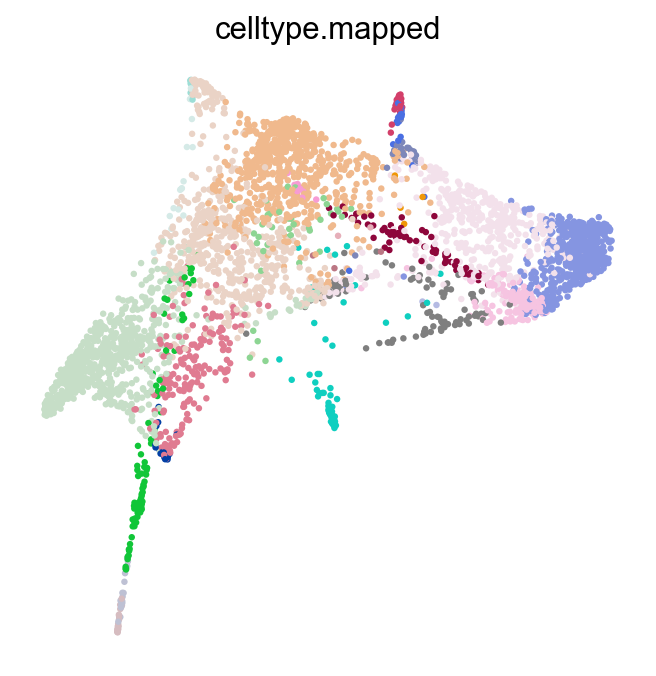

In [228]:
sc.pl.draw_graph(adata_qc, color='celltype.mapped', legend_loc='right')

In [229]:
sc.tl.umap(adata_qc, min_dist=0.5)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [230]:
adata_qc.obsm["X_umap"].shape

(3549, 2)

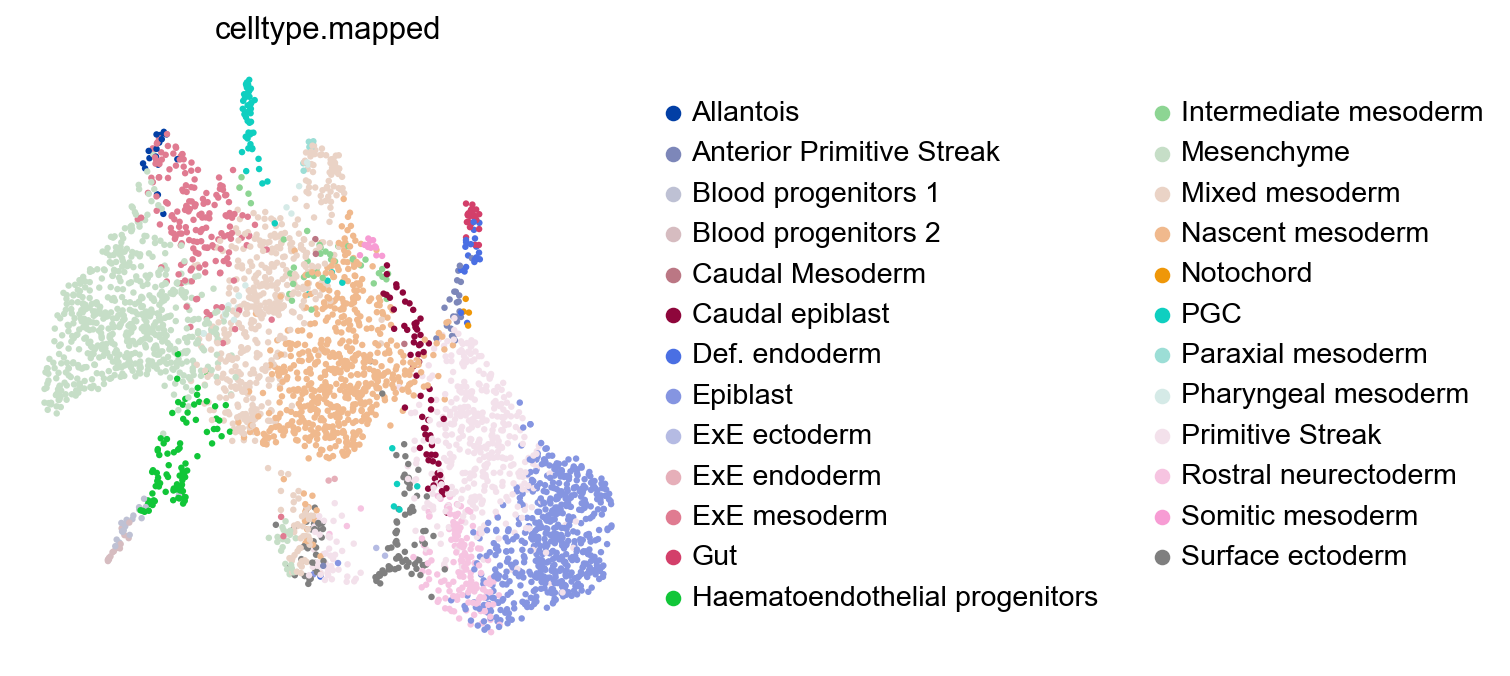

In [231]:
sc.pl.umap(adata_qc, color="celltype.mapped", legend_loc="right margin")

In [240]:
colPalette_celltypes = [opts["celltype.colors"][i.replace(" ","_")] for i in sorted(np.unique(adata_qc.obs['celltype.mapped']))]
adata_qc.uns['celltype.mapped_colors'] = colPalette_celltypes

In [244]:
colPalette_stages = [opts["stages_colors"][i.replace(" ","_")] for i in sorted(np.unique(adata_qc.obs['stage']))]
adata_qc.uns['stage_colors'] = colPalette_stages

/Users/ricard/anaconda3/envs/base_new/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


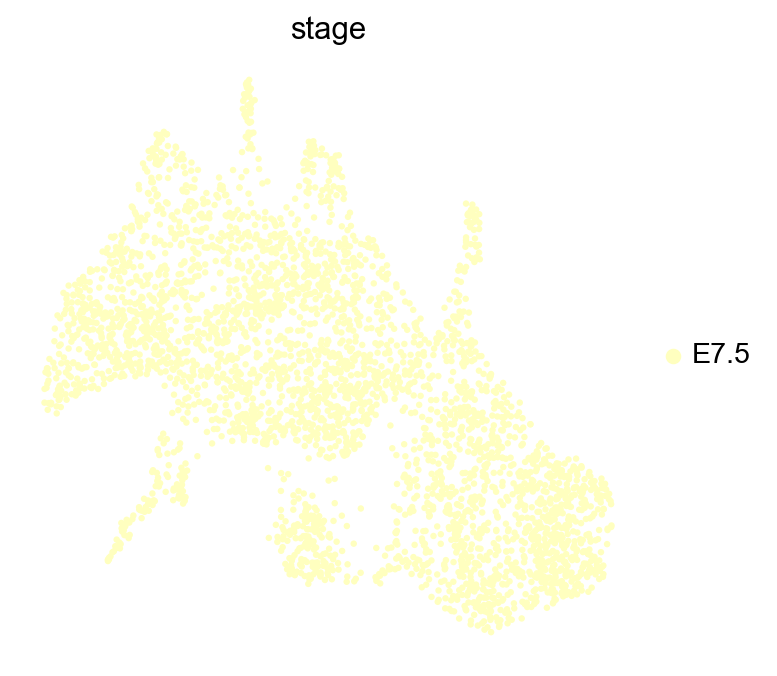

In [245]:
sc.pl.umap(adata_qc, color=['stage'], legend_loc='right margin')